In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

We import the important packages.

In [2]:
import torch
import torchvision
from torchvision import datasets
from PIL import Image

import csv
import os
import pandas as pd
from torch.utils.data import Dataset

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, SubsetRandomSampler

from torchvision.io import read_image, ImageReadMode
from torchvision.transforms import v2

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import numpy as np

We build a custom image dataset.

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, 'image_'+str(self.img_labels.iloc[idx, 0])+'.png')
        image = read_image(img_path, ImageReadMode.RGB)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label


We apply transformations to the images. We will also divide our training data set into three sets of training, validating, and testing.

   id  label
1   1      8
2   2      8
3   3      2
4   4      9
len train: 35000 len valid: 10000 len test: 5000
274


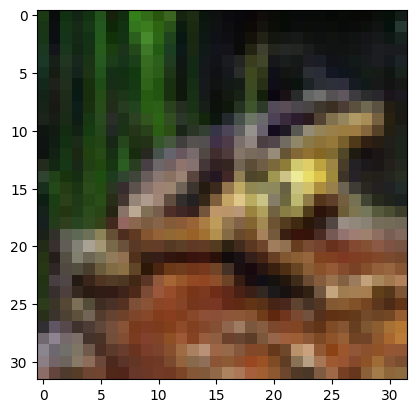

In [4]:
path_to_test_folder = '/kaggle/input/nzmsa-2024/cifar10_images/test'
path_to_train_folder = '/kaggle/input/nzmsa-2024/cifar10_images/train'

annotations_file = '/kaggle/input/nzmsa-2024/train.csv'
img_labels = pd.read_csv(annotations_file)
print(img_labels[1:5])
img_path = '/kaggle/input/nzmsa-2024/cifar10_images/train/image_0.png'

transform = v2.Compose([
    v2.Resize((32,32), antialias=True), # resizing
    v2.ToDtype(torch.float32, scale=True),  
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# loading the training data set
train_dataset = CustomImageDataset(annotations_file=annotations_file,
                                   img_dir=path_to_train_folder,
                                   transform = transform)
# Spliting the data into train_validation_test

batch_size=128
valid_size=0.2
test_size=0.1
train_length = len(train_dataset)

split_val_size = int(np.floor(valid_size * train_length))
split_test_size = int(np.floor(test_size * train_length))
split_train_size = train_length - split_test_size - split_val_size



train_split, valid_split, test_split =torch.utils.data.random_split(train_dataset, [split_train_size,split_val_size, split_test_size])
print(f'len train: { len(train_split)} len valid: { len(valid_split)} len test: { len(test_split)}')


train_dataloader = DataLoader(train_split,batch_size=batch_size,shuffle=True)
valid_dataloader = DataLoader(valid_split,batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_split,batch_size=batch_size,shuffle=False)


print(len(train_dataloader))
tensor_image=train_dataloader.dataset[80][0]
plt.imshow(tensor_image.permute(1, 2, 0))



Feature batch shape: torch.Size([128, 3, 32, 32])
Labels batch shape: torch.Size([128])


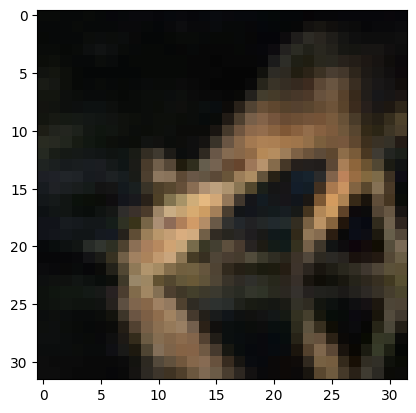

Label: Deer


In [5]:
label_names = { 0: 'Cat',
1: 'Horse',
2: 'Deer',
3: 'Ship',
4: 'Bird',
5: 'Dog',
6: 'Airplane',
7: 'Frog',
8: 'Truck',
9: 'Automobile'}

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.permute(1,2,0), cmap="gray")
plt.show()
print(f"Label: {label_names[label.item()]}")

We plot more images. This time, we plot them in gray.

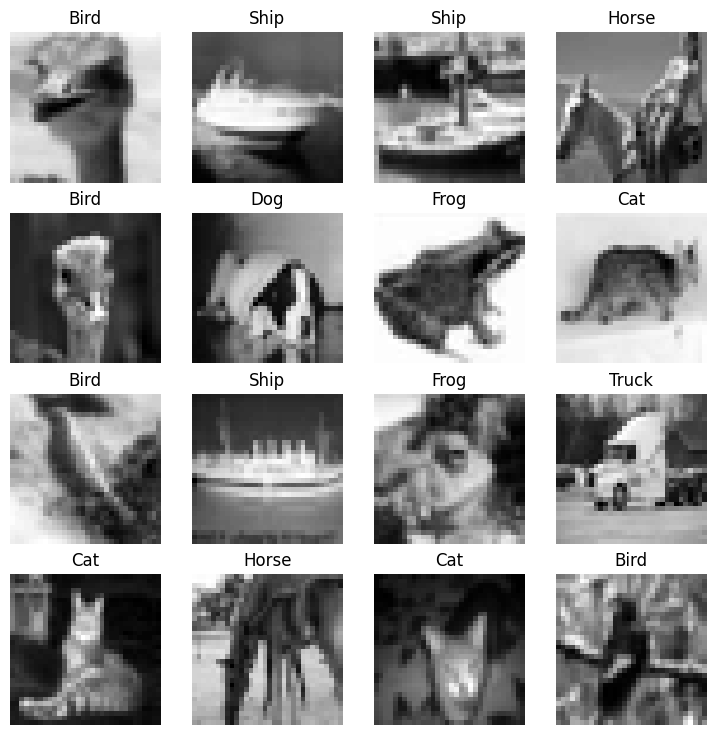

In [6]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_dataset), size=[1]).item()
    img, label = train_dataset[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img[0].squeeze(), cmap="gray")
    plt.title(label_names[label])
    plt.axis(False);

# Convolutional Neural Network 

Is GPU avaiable?

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


We define an accuracy function.

In [8]:
def accuracy_fn(y_true, y_pred):
    y_true=y_true.cpu().numpy()
    y_pred= y_pred.cpu().numpy()
    
    acc = accuracy_score(y_true,y_pred)
    return acc

# Building the model.

The model has two convolutional layers, each one is followed by a relu activation function. We then have a maxpooling layer after which batchnorm is applied. This is repeat three times. Finally, we have a flattening layer followed by two dense layers with relu activation.

In [9]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

# Define a convolution neural network

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32,5),
            nn.ReLU(),
            nn.Conv2d(32, 
                      64,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2),
            nn.BatchNorm2d(64),                

            nn.Conv2d(64, 128, 3,stride=1 ,padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size = 3,stride=1 ,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(128),
            
            nn.Conv2d(128, 256,kernel_size=3,stride=1 ,padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size = 3,stride=1 ,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(256),
            
            nn.Flatten(),
            nn.Linear(256*3*3, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )


    def forward(self, xb):
        return self.network(xb)

Model = Net().to(device)



We set up a loss function and optimizer. We will use Cross Entropy and SGD.

In [10]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(Model.parameters(), lr=0.001, momentum=0.9)

In what follows, we train the model.

In [11]:
epochs = 10

train_losses = []
train_acces = []

val_losses = []
val_acces = []

for epoch in range(epochs):
    print(f"Epoch: {epoch}\n-------")
    train_loss = 0
    train_acc = 0
    
    Model.train() 
    ###### 
    # Train loop
    #####
    for batch, data in enumerate(train_dataloader,0):
        
        inputs, labels = data
        
        inputs=inputs.to(device)
        labels=labels.to(device)
        
                
        #optimizer zero grad
        optimizer.zero_grad()
        
        # forward pass
        y_pred = Model(inputs)
        

        # calculate the loss
        loss = loss_fn(y_pred, labels)
        # loss backward
        loss.backward()
        # optimizer step
        optimizer.step()
        
        # accumulate loss
        train_loss += loss.item()  
        
        _,y_preds=torch.max(y_pred,1)
        train_acc += accuracy_fn(labels, y_preds)

        

        if batch % 50 == 0:
            print(f"Looked at {batch * len(data)}/{len(train_dataloader.dataset)} samples")

    train_loss_avg = train_loss / len(train_dataloader)
    train_acc_avg = train_acc / len(train_dataloader)
    
    train_losses.append(train_loss_avg)
    train_acces.append(train_acc_avg)
     
    ###### 
    # Validation loop
    #####
    val_loss, val_acc = 0, 0 
    Model.eval()
    with torch.inference_mode():
        for batch, data in enumerate(valid_dataloader,0):
            
            val_inputs, val_labels = data
            
            val_inputs=val_inputs.to(device)
            val_labels=val_labels.to(device)
            
            # forward pass
            val_pred = Model(val_inputs)
           
            # calculate the loss
            val_loss += loss_fn(val_pred,val_labels).item()
            _,val_preds=torch.max(val_pred,1)
            val_acc += accuracy_fn(val_labels, val_preds)
        
    val_loss_avg = val_loss / len(valid_dataloader)

    val_acc_avg = val_acc / len(valid_dataloader)

    val_losses.append(val_loss_avg)
    val_acces.append(val_acc_avg)

    print(f"Val loss: {val_loss_avg:.5f}, Val acc: {val_acc_avg*100:.2f}%\n")
    
print('Finished')

Epoch: 0
-------
Looked at 0/35000 samples
Looked at 100/35000 samples
Looked at 200/35000 samples
Looked at 300/35000 samples
Looked at 400/35000 samples
Looked at 500/35000 samples
Val loss: 1.61744, Val acc: 40.74%

Epoch: 1
-------
Looked at 0/35000 samples
Looked at 100/35000 samples
Looked at 200/35000 samples
Looked at 300/35000 samples
Looked at 400/35000 samples
Looked at 500/35000 samples
Val loss: 1.39536, Val acc: 49.79%

Epoch: 2
-------
Looked at 0/35000 samples
Looked at 100/35000 samples
Looked at 200/35000 samples
Looked at 300/35000 samples
Looked at 400/35000 samples
Looked at 500/35000 samples
Val loss: 1.11512, Val acc: 60.13%

Epoch: 3
-------
Looked at 0/35000 samples
Looked at 100/35000 samples
Looked at 200/35000 samples
Looked at 300/35000 samples
Looked at 400/35000 samples
Looked at 500/35000 samples
Val loss: 1.21970, Val acc: 57.43%

Epoch: 4
-------
Looked at 0/35000 samples
Looked at 100/35000 samples
Looked at 200/35000 samples
Looked at 300/35000 sampl

In [12]:
# train_losses=[item.cpu() for item in train_losses]
print(train_losses)
t=np.array(train_losses)

[1.8326840004781737, 1.3076967427330295, 1.057910623124046, 0.8906555650007986, 0.751941434875892, 0.6224478624597953, 0.5044592489508817, 0.38350505583042643, 0.26871957298177873, 0.16892114781985318]


## Plot metrics
We plot the loss and accuracy for train set and validation set, and we will compare them.

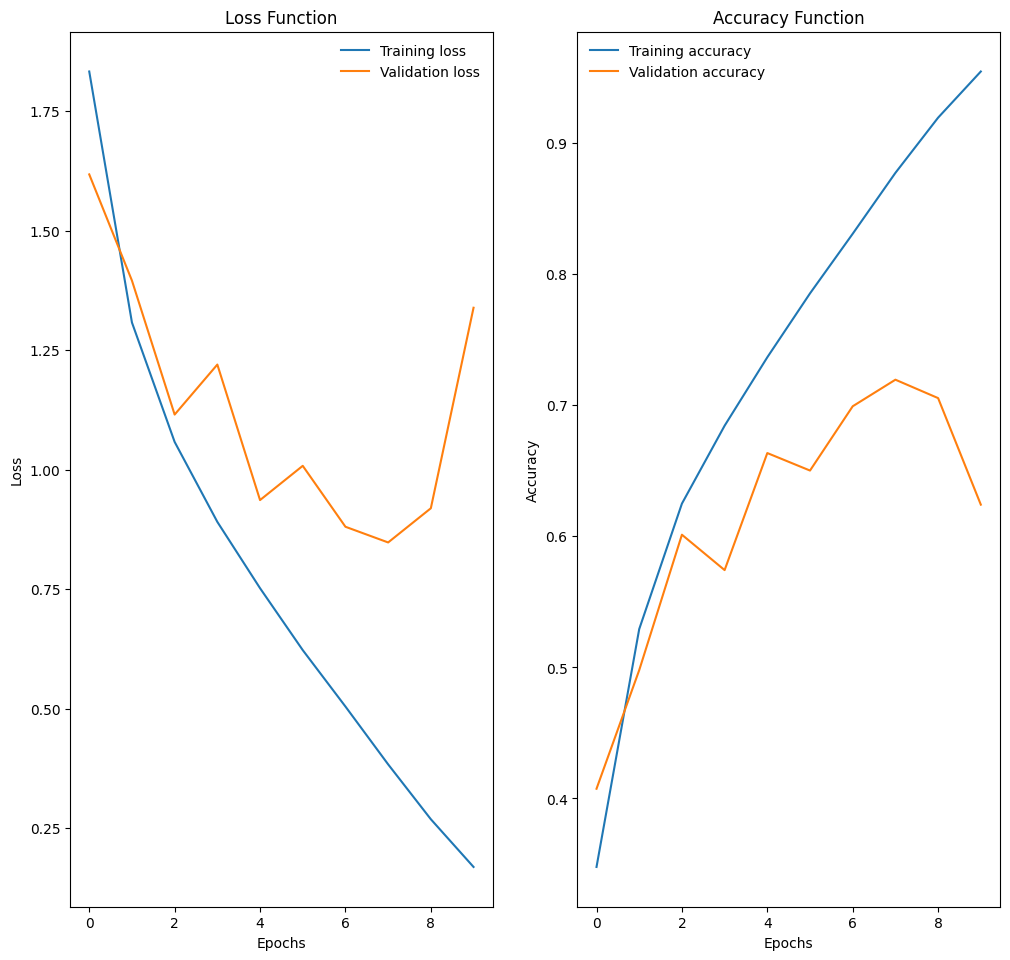

In [13]:
# plot loss
plt.figure(figsize=(12, 25))
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Function")
plt.legend(frameon=False)

# plot accuraccy
plt.subplot(2, 2, 2)
plt.plot(train_acces, label = 'Training accuracy')
plt.plot(val_acces, label = 'Validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Function")
plt.legend(frameon=False)

The training accuracy is clearly increasing as the number of epochs increases. On the other hand, the validation accuracy initially increases as the model starts learning . That being said, after certain epoch it starts fluctuating and a big gap between validation and train appears. This can be due to the fact the model is failing to generalize to the unseen data.

## Saving the model

In [14]:
PATH = './net.pth'
torch.save(Model.state_dict(), PATH)

# Confusion matrix.

Plotting from the test set.

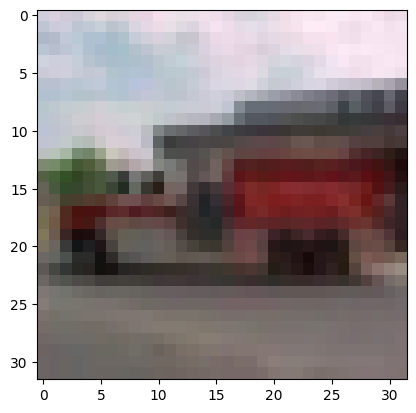

Label: Truck


In [15]:
test_features, test_labels = next(iter(test_dataloader))

img = test_features[0].squeeze()
label = test_labels[0]
plt.imshow(img.permute(1,2,0), cmap="gray")
plt.show()
print(f"Label: {label_names[label.item()]}")

In [16]:
# Get predictions from test split for further model evaluation
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_dataloader:
    
        inputs=inputs.to(device)
        labels=labels.to(device)
        output = Model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

The f1 is 0.6311987243153383 accuracy is 0.6252, recall is 0.6252,
 and precision score is 0.7162977839008705


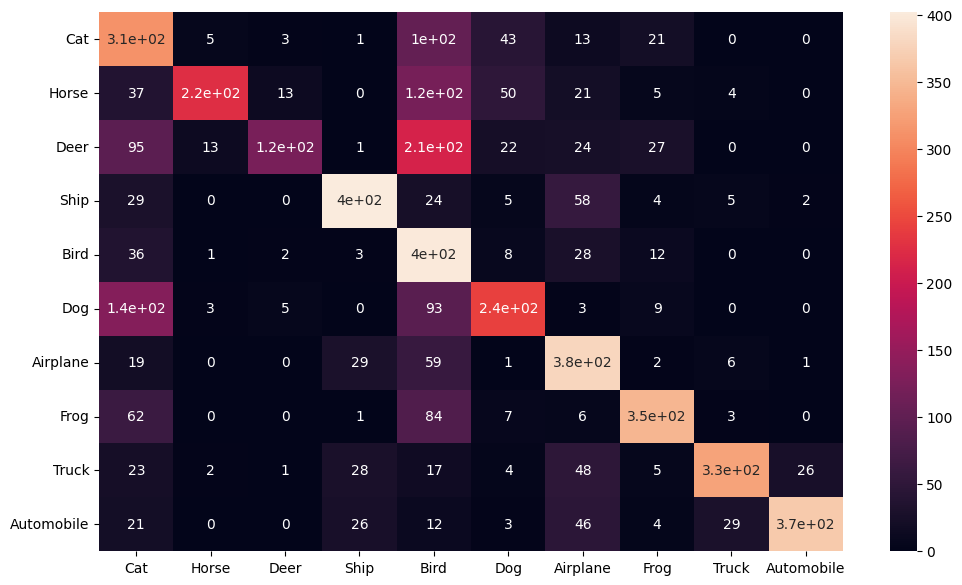

In [17]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
import seaborn as sn
import pandas as pd


classes = label_names = ('Cat','Horse','Deer','Ship','Bird','Dog','Airplane','Frog','Truck','Automobile')

# Build confusion matrix
y_True = torch.tensor(y_true)
y_Pred = torch.tensor(y_pred)

f1 = f1_score(y_true,y_pred,average='weighted')
acc = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred,average='weighted', zero_division=1)
prec = precision_score(y_true, y_pred,average='weighted', zero_division=1)
print(f"The f1 is {f1} accuracy is {acc}, recall is {recall},\n and precision score is {prec}")


# Setting up the confusion matrix
cf_matrix = confusion_matrix(y_True, y_Pred)
df_cm = pd.DataFrame(cf_matrix , index = [i for i in classes],
                     columns = [i for i in classes])


# Plotting the confusion matrix
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')


The model seems to be doing well in general. But, clearly, from the above, we can see there are certain instances which the model get wrong. For example, "Dog" and "Cat" get mixed up quite often.

## Predict test images for submission

In [18]:
import fnmatch
path_test_dir = '/kaggle/input/nzmsa-2024/cifar10_images/test'

num_test_images = len(fnmatch.filter(os.listdir(path_test_dir), '*.png'))


#Define a transformation to apply to images
test_transform = v2.Compose([
    v2.Resize((32,32), antialias=True),#Resize images
    v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),# Convert data to a normalized torch.FloatTensor
])

@torch.no_grad()
def classify(image_path,image_transform):
    image =  read_image(image_path, ImageReadMode.RGB)
    image_tensor = image_transform(image)
    image_tensor.unsqueeze_(0)
    image_tensor=image_tensor.to(device)
    output = Model(image_tensor)
    index = output.cpu().data.numpy().argmax()
    return index

preds = []
#test image
for i in range(num_test_images):
    path_test_image=os.path.join(path_test_dir, 'image_'+str(i)+'.png')
    prediction_label = classify(path_test_image, test_transform)
    preds.append([i, prediction_label])


In [19]:
# opening csv file

file = open('submission.csv', 'w+', newline = '')

with file:
    write = csv.writer(file)
    write.writerows([["id","label"]])
    write.writerows(preds)

# Summary

For this task, I implemented a convolutional neural network. Creating a train-validation-test split from the images in the train folder we trained and evaluated our model tracking the loss and accurracy over each epoch. Following this we used our fully trained model on the test split to gain further insight into our fully trained model. The confusion matrix indicated roughly 70% accurracy but a mix up between dogs and cats occurs. 

Although we implemented batch normalisation in between convolution layers to help address overfitting this did not sufice to prevent it. 

Further techniques such as adding dropout layers, or early stopping or further data augmentation transforms could be applied to remedy the issue and increase the generalization performance of our model.